# Hospital Readmission Prediction

The Hospital Readmissions Reduction Program (HRRP) is a program that encourages hospitals to improve communication and care coordination to better engage patients and caregivers in
discharge plans and, in turn, reduce avoidable readmissions. Hospitals with relatively higher rates of readmission may be fined by the government. An acute care hospital is trying to avoid fines from the government by ensuring that their 30-day
readmission rate is not excessively high. As a data scientist, your task is to develop a predictive model to identify patients who are likely to be readmitted within 30 days of discharge so that the hospital can take proactive measures to reduce the risk.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Installations

In [2]:
!pip install pandas-profiling[notebook,html]
!pip install duckdb
!pip install yellowbrick



In [3]:
!pip uninstall numba
!pip install -U numba

Found existing installation: numba 0.57.1
Uninstalling numba-0.57.1:
  Would remove:
    /usr/local/bin/numba
    /usr/local/lib/python3.10/dist-packages/numba-0.57.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/numba/*
Proceed (Y/n)? y
  Successfully uninstalled numba-0.57.1
  Using cached numba-0.57.1-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (3.6 MB)


### Importing Libraries

In [4]:
# Starting with standard imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
from sklearn.model_selection import train_test_split
from pandas_profiling import ProfileReport
from pandas_profiling.utils.cache import cache_file
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import normalize
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.classifier.confusion_matrix import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ROCAUC
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/usr/local/lib/python3.10/dist-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:
<ipython-input-4-9ae4d6b26de2>:9: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling`

### Loading Data

In [5]:
admission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Vigilanz/ADMISSIONS.csv')
drgcode = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Vigilanz/DRGCODES.csv')
labevent = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Vigilanz/LABEVENTS 2.csv')
patient = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Vigilanz/PATIENTS.csv')

## Exploratory Data Analysis
Starting the journey with admission tables and trying to understand features.

#### Admissions

In [6]:
admission.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [7]:
print('Admissions dataset has {} events in total.'.format(admission['ROW_ID'].nunique()))
print('Admissions dataset has {} unique admission events.'.format(admission['HADM_ID'].nunique()))
print('Admissions dataset has {} unique patients.'.format(admission['SUBJECT_ID'].nunique()))

Admissions dataset has 58976 events in total.
Admissions dataset has 58976 unique admission events.
Admissions dataset has 46520 unique patients.


Converting Admit time and such variables to DateTime Data Type object--> datetime

In [8]:
admission[['ADMITTIME','DISCHTIME','DEATHTIME','EDREGTIME','EDOUTTIME']] = admission[['ADMITTIME','DISCHTIME','DEATHTIME','EDREGTIME','EDOUTTIME']].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S'))

Descriptive Stats on Admissions Data

In [9]:
admission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ROW_ID                58976 non-null  int64         
 1   SUBJECT_ID            58976 non-null  int64         
 2   HADM_ID               58976 non-null  int64         
 3   ADMITTIME             58976 non-null  datetime64[ns]
 4   DISCHTIME             58976 non-null  datetime64[ns]
 5   DEATHTIME             5854 non-null   datetime64[ns]
 6   ADMISSION_TYPE        58976 non-null  object        
 7   ADMISSION_LOCATION    58976 non-null  object        
 8   DISCHARGE_LOCATION    58976 non-null  object        
 9   INSURANCE             58976 non-null  object        
 10  LANGUAGE              33644 non-null  object        
 11  RELIGION              58518 non-null  object        
 12  MARITAL_STATUS        48848 non-null  object        
 13  ETHNICITY       

In [10]:
admission.describe()

,ROW_ID,SUBJECT_ID,HADM_ID,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
count,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000
mean,29488.500000,33755.583288,149970.809584,0.099261,0.973006
std,17025.049075,28092.726225,28883.095213,0.299014,0.162067
min,1.000000,2.000000,100001.000000,0.000000,0.000000
25%,14744.750000,11993.750000,124952.750000,0.000000,1.000000
50%,29488.500000,24133.500000,149989.500000,0.000000,1.000000
75%,44232.250000,53851.500000,174966.500000,0.000000,1.000000
max,58976.000000,99999.000000,199999.000000,1.000000,1.000000


Adding Duration as one of the predictors by using discharge time and admit time

In [11]:
admission['DURATION'] = (admission['DISCHTIME'] - admission['ADMITTIME']).dt.total_seconds()/86400


In [12]:
admission['DURATION'] = admission['DURATION'].apply(np.ceil)

In [13]:
admission[['ADMITTIME','DISCHTIME','DURATION']].head(5)

,ADMITTIME,DISCHTIME,DURATION
0,2196-04-09 12:26:00,2196-04-10 15:54:00,2.0
1,2153-09-03 07:15:00,2153-09-08 19:10:00,6.0
2,2157-10-18 19:34:00,2157-10-25 14:00:00,7.0
3,2139-06-06 16:14:00,2139-06-09 12:48:00,3.0
4,2160-11-02 02:06:00,2160-11-05 14:55:00,4.0


In [14]:
admission.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
       'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA', 'DURATION'],
      dtype='object')

Looking at the distribution of days

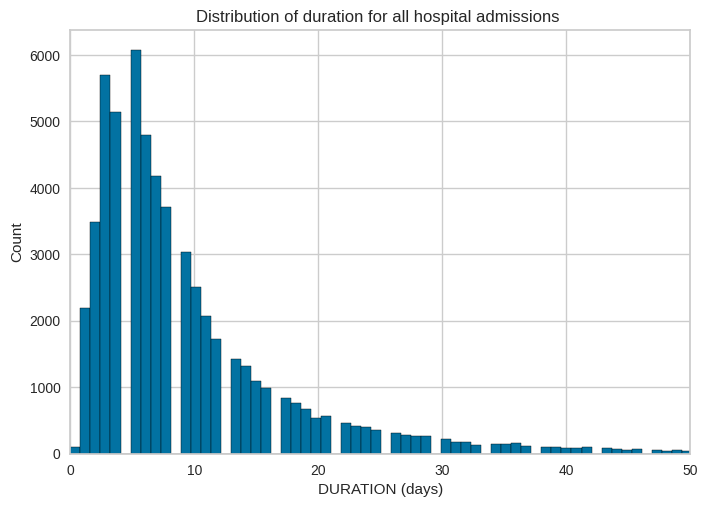

In [15]:
#Histogram of distribution
plt.hist(admission['DURATION'], bins=365, edgecolor = 'black')
plt.xlim(0, 50)
plt.title('Distribution of duration for all hospital admissions ')
plt.ylabel('Count')
plt.xlabel('DURATION (days)')
plt.tick_params(top=False, right=False)
plt.show();

Query for adding the target variable READMITIN30

Performed an operation to calculate the target variable.
For each patient, computed the intervals between his two sebsequent admissions. If the interval is shorter than 30 days, the readmission label for the encounter is 1; otherwise the readmission label is 0.

In [16]:
queryreadmit = duckdb.query("SELECT * FROM (SELECT admission.*, RANK() OVER(PARTITION BY SUBJECT_ID ORDER BY ADMITTIME) AS ADMIT_RANK FROM admission) a LEFT JOIN (SELECT SUBJECT_ID, MAX(ADMIT_RANK) AS MAX_ADMIT_RANK FROM (SELECT admission.*, RANK() OVER(PARTITION BY SUBJECT_ID ORDER BY ADMITTIME) AS ADMIT_RANK FROM admission) GROUP BY SUBJECT_ID) b ON a.SUBJECT_ID = b.SUBJECT_ID")



```
SELECT
  *
FROM
  (
    SELECT
      admission.*,
      RANK() OVER(
        PARTITION BY SUBJECT_ID
        ORDER BY
          ADMITTIME
      ) AS ADMIT_RANK
    FROM
      admission
  ) a
  LEFT JOIN (
    SELECT
      SUBJECT_ID,
      MAX(ADMIT_RANK) AS MAX_ADMIT_RANK
    FROM
      (
        SELECT
          admission.*,
          RANK() OVER(
            PARTITION BY SUBJECT_ID
            ORDER BY
              ADMITTIME
          ) AS ADMIT_RANK
        FROM
          admission
      )
    GROUP BY
      SUBJECT_ID
  ) b ON a.SUBJECT_ID = b.SUBJECT_ID


```



In [17]:
queryreadmit = queryreadmit.df()
queryreadmit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ROW_ID                58976 non-null  int64         
 1   SUBJECT_ID            58976 non-null  int64         
 2   HADM_ID               58976 non-null  int64         
 3   ADMITTIME             58976 non-null  datetime64[ns]
 4   DISCHTIME             58976 non-null  datetime64[ns]
 5   DEATHTIME             5854 non-null   datetime64[ns]
 6   ADMISSION_TYPE        58976 non-null  object        
 7   ADMISSION_LOCATION    58976 non-null  object        
 8   DISCHARGE_LOCATION    58976 non-null  object        
 9   INSURANCE             58976 non-null  object        
 10  LANGUAGE              33644 non-null  object        
 11  RELIGION              58518 non-null  object        
 12  MARITAL_STATUS        48848 non-null  object        
 13  ETHNICITY       

In [18]:
admit_next = queryreadmit['ADMITTIME'].values[1:]
admit_next = np.append(admit_next, admit_next[0])
queryreadmit['NEXT_ADMIT'] = admit_next
queryreadmit['READMITIN30'] = -1
queryreadmit.loc[queryreadmit['ADMIT_RANK'] == queryreadmit['MAX_ADMIT_RANK'], 'READMITIN30'] = 0
readmit_sub_df = queryreadmit[queryreadmit['READMITIN30']==-1]
interval = (readmit_sub_df['NEXT_ADMIT'] - readmit_sub_df['DISCHTIME']).dt.days.values
queryreadmit.loc[queryreadmit['READMITIN30']==-1, 'INTERVAL'] = interval
queryreadmit.loc[queryreadmit['INTERVAL']<=30, 'READMITIN30'] = 1
queryreadmit.loc[queryreadmit['INTERVAL']>30, 'READMITIN30'] = 0

In [19]:
queryreadmit.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
       'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA', 'DURATION',
       'ADMIT_RANK', 'SUBJECT_ID_2', 'MAX_ADMIT_RANK', 'NEXT_ADMIT',
       'READMITIN30', 'INTERVAL'],
      dtype='object')

Distribution of Target Variable

In [20]:
queryreadmit['READMITIN30'].value_counts()


0    55518
1     3458
Name: READMITIN30, dtype: int64

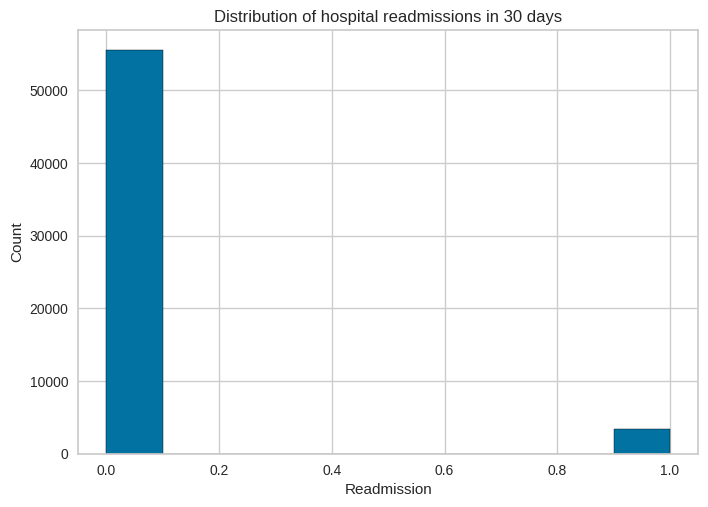

In [21]:
plt.hist(queryreadmit['READMITIN30'], edgecolor = 'black')
plt.title('Distribution of hospital readmissions in 30 days')
plt.ylabel('Count')
plt.xlabel('Readmission')
plt.tick_params(top=False, right=False)
plt.show();

#### Missing Values Analysis

In [22]:
queryreadmit.isnull().sum()

ROW_ID                      0
SUBJECT_ID                  0
HADM_ID                     0
ADMITTIME                   0
DISCHTIME                   0
DEATHTIME               53122
ADMISSION_TYPE              0
ADMISSION_LOCATION          0
DISCHARGE_LOCATION          0
INSURANCE                   0
LANGUAGE                25332
RELIGION                  458
MARITAL_STATUS          10128
ETHNICITY                   0
EDREGTIME               28099
EDOUTTIME               28099
DIAGNOSIS                  25
HOSPITAL_EXPIRE_FLAG        0
HAS_CHARTEVENTS_DATA        0
DURATION                    0
ADMIT_RANK                  0
SUBJECT_ID_2                0
MAX_ADMIT_RANK              0
NEXT_ADMIT                  0
READMITIN30                 0
INTERVAL                46520
dtype: int64

In [23]:
percent_missing = queryreadmit.isnull().sum()*100/len(queryreadmit)
percent_missing

ROW_ID                   0.000000
SUBJECT_ID               0.000000
HADM_ID                  0.000000
ADMITTIME                0.000000
DISCHTIME                0.000000
DEATHTIME               90.073928
ADMISSION_TYPE           0.000000
ADMISSION_LOCATION       0.000000
DISCHARGE_LOCATION       0.000000
INSURANCE                0.000000
LANGUAGE                42.953066
RELIGION                 0.776587
MARITAL_STATUS          17.173087
ETHNICITY                0.000000
EDREGTIME               47.644805
EDOUTTIME               47.644805
DIAGNOSIS                0.042390
HOSPITAL_EXPIRE_FLAG     0.000000
HAS_CHARTEVENTS_DATA     0.000000
DURATION                 0.000000
ADMIT_RANK               0.000000
SUBJECT_ID_2             0.000000
MAX_ADMIT_RANK           0.000000
NEXT_ADMIT               0.000000
READMITIN30              0.000000
INTERVAL                78.879544
dtype: float64

#### Assumption
Remove deceased rows from table using death time
Reason: We are trying to predict readmission of a patient and a deceased patient is unlikely to get readmitted, hence removing them from out predictors

In [24]:
queryreadmit = queryreadmit[queryreadmit['DEATHTIME'].isna()]


In [25]:
queryreadmit.shape

(53122, 26)

Language have missing values, lets look at the value counts

In [26]:
queryreadmit['LANGUAGE'].value_counts()


ENGL    26580
SPAN      997
RUSS      671
PTUN      515
CANT      355
        ...  
*AMH        1
*PHI        1
*CRE        1
*PUN        1
*FUL        1
Name: LANGUAGE, Length: 72, dtype: int64

We see there is an unknown category and hence we will add the missing values also the same category.

In [27]:
queryreadmit['LANGUAGE'] = queryreadmit['LANGUAGE'].fillna('unknown')

Same goes with Marital Status and Religion

In [28]:
queryreadmit['MARITAL_STATUS'].value_counts()

MARRIED              21629
SINGLE               12162
WIDOWED               6158
DIVORCED              2894
SEPARATED              517
UNKNOWN (DEFAULT)      280
LIFE PARTNER            15
Name: MARITAL_STATUS, dtype: int64

In [29]:
queryreadmit['MARITAL_STATUS'] = queryreadmit['MARITAL_STATUS'].fillna('UNKNOWN (DEFAULT)')

In [30]:
queryreadmit['RELIGION'].value_counts()

CATHOLIC                  18685
NOT SPECIFIED             10816
UNOBTAINABLE               7156
PROTESTANT QUAKER          6476
JEWISH                     4644
OTHER                      2480
EPISCOPALIAN                707
GREEK ORTHODOX              421
CHRISTIAN SCIENTIST         397
BUDDHIST                    248
MUSLIM                      212
JEHOVAH'S WITNESS           122
UNITARIAN-UNIVERSALIST      106
HINDU                       104
7TH DAY ADVENTIST            76
ROMANIAN EAST. ORTH          72
BAPTIST                      20
HEBREW                       12
METHODIST                     6
LUTHERAN                      1
Name: RELIGION, dtype: int64

In [31]:
queryreadmit['RELIGION'] = queryreadmit['RELIGION'].fillna('NOT SPECIFIED')

Diagnosis is high in cardinality and since its a categorical variable, we might need to find an alternative

In [32]:
queryreadmit['DIAGNOSIS'].value_counts()

NEWBORN                                                                           7761
PNEUMONIA                                                                         1302
SEPSIS                                                                             917
CORONARY ARTERY DISEASE                                                            817
CONGESTIVE HEART FAILURE                                                           802
                                                                                  ... 
RAPID ATRIAL FIBRILLATION;STATUS POST LIVER TRANSPLANT                               1
COPD FLARE;SHORTNESS OF BREATH;RULE OUT MYOCARDIAL INFARCTION                        1
AORTIC ANEURYSM\ BENTAL PROCEDURE VS VALVE SPARING AORTIC ROOT REPLACEMENT/SDA       1
CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS GRAFT; X3/SDA                         1
PENCARDIAL EFFUSION;HYPOXIA                                                          1
Name: DIAGNOSIS, Length: 14231, dtype: int6

In [33]:
queryreadmit['DIAGNOSIS'] = queryreadmit['DIAGNOSIS'].fillna('UNKNOWN')

In [34]:
percent_missing = queryreadmit.isnull().sum()*100/len(queryreadmit)
percent_missing

ROW_ID                    0.000000
SUBJECT_ID                0.000000
HADM_ID                   0.000000
ADMITTIME                 0.000000
DISCHTIME                 0.000000
DEATHTIME               100.000000
ADMISSION_TYPE            0.000000
ADMISSION_LOCATION        0.000000
DISCHARGE_LOCATION        0.000000
INSURANCE                 0.000000
LANGUAGE                  0.000000
RELIGION                  0.000000
MARITAL_STATUS            0.000000
ETHNICITY                 0.000000
EDREGTIME                49.565152
EDOUTTIME                49.565152
DIAGNOSIS                 0.000000
HOSPITAL_EXPIRE_FLAG      0.000000
HAS_CHARTEVENTS_DATA      0.000000
DURATION                  0.000000
ADMIT_RANK                0.000000
SUBJECT_ID_2              0.000000
MAX_ADMIT_RANK            0.000000
NEXT_ADMIT                0.000000
READMITIN30               0.000000
INTERVAL                 76.636798
dtype: float64

#### Patient Information

Going Over to Patients Table to see if we can extract features

In [41]:
patient.head()

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,AGE
0,234,249,F,2075-03-13,NaN,NaN,NaN,0,-52.0
1,235,250,F,2164-12-27,2188-11-22 00:00:00,2188-11-22 00:00:00,NaN,1,-142.0
2,236,251,M,2090-03-15,NaN,NaN,NaN,0,-67.0
3,237,252,M,2078-03-06,NaN,NaN,NaN,0,-55.0
4,238,253,F,2089-11-26,NaN,NaN,NaN,0,-67.0


Converting to datetime

In [36]:
patient[['DOB']] = patient[['DOB']].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S'))


In [37]:
patient['DOB']

0       2075-03-13
1       2164-12-27
2       2090-03-15
3       2078-03-06
4       2089-11-26
           ...    
46515   2026-05-25
46516   2124-07-27
46517   2049-11-26
46518   2076-07-25
46519   2098-07-25
Name: DOB, Length: 46520, dtype: datetime64[ns]

#### Assumption Age
Adding a feature called AGE using the date of birth of a patient assuming the dates represent real time data

In [38]:
current_date = pd.to_datetime('today')
patient['AGE'] = (current_date - patient['DOB']).astype('<m8[Y]')

In [39]:
patient['AGE']

0        -52.0
1       -142.0
2        -67.0
3        -55.0
4        -67.0
         ...  
46515     -3.0
46516   -102.0
46517    -27.0
46518    -54.0
46519    -76.0
Name: AGE, Length: 46520, dtype: float64

In [40]:
patient.shape

(46520, 9)

#### Assumption Deceased
Removing the deceased rows

In [42]:
patient = patient[patient['DOD'].isna()]

In [44]:
patient.shape

(30761, 9)

In [45]:
patiens_removed = 46520 - 30761
patiens_removed

15759

Validating the removal

In [46]:
patient['EXPIRE_FLAG'].value_counts()

0    30761
Name: EXPIRE_FLAG, dtype: int64

In [47]:
patient = patient[['SUBJECT_ID', 'DOB', 'GENDER','AGE']]
patient.head()

,SUBJECT_ID,DOB,GENDER,AGE
0,249,2075-03-13,F,-52.0
2,251,2090-03-15,M,-67.0
3,252,2078-03-06,M,-55.0
4,253,2089-11-26,F,-67.0
5,255,2109-08-05,M,-87.0


Merging the datasets of admission and patient demographics

In [48]:
merge_admin_patient = queryreadmit.merge(patient, how='inner', on='SUBJECT_ID')

In [49]:
merge_admin_patient.shape

(36390, 29)

In [50]:
merge_admin_patient.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
       'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA', 'DURATION',
       'ADMIT_RANK', 'SUBJECT_ID_2', 'MAX_ADMIT_RANK', 'NEXT_ADMIT',
       'READMITIN30', 'INTERVAL', 'DOB', 'GENDER', 'AGE'],
      dtype='object')

#### DRGCodes

Looking into DRG Codes Table

In [51]:
drgcode.shape

(125557, 8)

In [52]:
drgcode.head(20)

,ROW_ID,SUBJECT_ID,HADM_ID,DRG_TYPE,DRG_CODE,DESCRIPTION,DRG_SEVERITY,DRG_MORTALITY
0,342,2491,144486,HCFA,28,"TRAUMATIC STUPOR & COMA, COMA <1 HR AGE >17 WI...",NaN,NaN
1,343,24958,162910,HCFA,110,MAJOR CARDIOVASCULAR PROCEDURES WITH COMPLICAT...,NaN,NaN
2,344,18325,153751,HCFA,390,NEONATE WITH OTHER SIGNIFICANT PROBLEMS,NaN,NaN
3,345,17887,182692,HCFA,14,SPECIFIC CEREBROVASCULAR DISORDERS EXCEPT TRAN...,NaN,NaN
4,346,11113,157980,HCFA,390,NEONATE WITH OTHER SIGNIFICANT PROBLEMS,NaN,NaN
5,347,23705,154221,HCFA,385,"NEONATES, DIED OR TRANSFERRED TO ANOTHER ACUTE...",NaN,NaN
6,348,15787,122380,HCFA,105,CARDIAC VALVE & OTHER MAJOR CARDIOTHORACIC PRO...,NaN,NaN
7,349,13933,194891,HCFA,101,OTHER RESPIRATORY SYSTEM DIAGNOSES WITH COMPLI...,NaN,NaN
8,350,23976,171485,HCFA,107,CORONARY BYPASS WITH CARDIAC CATHETER,NaN,NaN
9,351,4351,164767,HCFA,14,SPECIFIC CEREBROVASCULAR DISORDERS EXCEPT TRAN...,NaN,NaN


In [53]:
drgcode['DRG_MORTALITY'].value_counts()

4.0    19684
3.0    18726
2.0    14752
1.0    13471
0.0        1
Name: DRG_MORTALITY, dtype: int64

In [54]:
drgcode.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'DRG_TYPE', 'DRG_CODE',
       'DESCRIPTION', 'DRG_SEVERITY', 'DRG_MORTALITY'],
      dtype='object')

In [55]:
drgcode.shape

(125557, 8)

In [56]:
drgcodemerge = drgcode[['SUBJECT_ID','HADM_ID','DRG_TYPE','DRG_CODE']]

In [57]:
drgcodemerge['DRG_CODE'].value_counts()

7204    3042
391     2653
1662    1367
6402    1342
871     1226
        ... 
708        1
60         1
5422       1
6344       1
758        1
Name: DRG_CODE, Length: 1667, dtype: int64

In [58]:
drgcodemerge['DRG_TYPE'].value_counts()

APR     66634
HCFA    31644
MS      27279
Name: DRG_TYPE, dtype: int64

In [59]:
drgcodemerge.shape

(125557, 4)

In [60]:
merge_admin_patient.shape

(36390, 29)

Joining the DRGCodes dataset on our previous dataset on patient id and hospital admission id.

In [61]:

merge_admin_patient_drgcode = pd.merge(merge_admin_patient, drgcodemerge, on=['SUBJECT_ID', 'HADM_ID'], how='inner')

In [62]:
merge_admin_patient_drgcode.shape

(79505, 31)

In [63]:

merge_admin_patient_drgcode.isnull().sum()*100/len(queryreadmit)

ROW_ID                    0.000000
SUBJECT_ID                0.000000
HADM_ID                   0.000000
ADMITTIME                 0.000000
DISCHTIME                 0.000000
DEATHTIME               149.664922
ADMISSION_TYPE            0.000000
ADMISSION_LOCATION        0.000000
DISCHARGE_LOCATION        0.000000
INSURANCE                 0.000000
LANGUAGE                  0.000000
RELIGION                  0.000000
MARITAL_STATUS            0.000000
ETHNICITY                 0.000000
EDREGTIME                74.607507
EDOUTTIME                74.607507
DIAGNOSIS                 0.000000
HOSPITAL_EXPIRE_FLAG      0.000000
HAS_CHARTEVENTS_DATA      0.000000
DURATION                  0.000000
ADMIT_RANK                0.000000
SUBJECT_ID_2              0.000000
MAX_ADMIT_RANK            0.000000
NEXT_ADMIT                0.000000
READMITIN30               0.000000
INTERVAL                125.337901
DOB                       0.000000
GENDER                    0.000000
AGE                 

#### LabEvents

Looking into Lab Event Table

In [64]:
labevent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27854055 entries, 0 to 27854054
Data columns (total 9 columns):
 #   Column      Dtype  
---  ------      -----  
 0   ROW_ID      int64  
 1   SUBJECT_ID  int64  
 2   HADM_ID     float64
 3   ITEMID      int64  
 4   CHARTTIME   object 
 5   VALUE       object 
 6   VALUENUM    float64
 7   VALUEUOM    object 
 8   FLAG        object 
dtypes: float64(2), int64(3), object(4)
memory usage: 1.9+ GB


In [65]:
labevent.head(10)

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG
0,281,3,NaN,50820,2101-10-12 16:07:00,7.39,7.39,units,NaN
1,282,3,NaN,50800,2101-10-12 18:17:00,ART,NaN,NaN,NaN
2,283,3,NaN,50802,2101-10-12 18:17:00,-1,-1.00,mEq/L,NaN
3,284,3,NaN,50804,2101-10-12 18:17:00,22,22.00,mEq/L,NaN
4,285,3,NaN,50808,2101-10-12 18:17:00,0.93,0.93,mmol/L,abnormal
5,286,3,NaN,50812,2101-10-12 18:17:00,NOT INTUBATED,NaN,NaN,NaN
6,287,3,NaN,50813,2101-10-12 18:17:00,1.8,1.80,mmol/L,NaN
7,288,3,NaN,50818,2101-10-12 18:17:00,33,33.00,mm Hg,NaN
8,289,3,NaN,50820,2101-10-12 18:17:00,7.42,7.42,units,NaN
9,290,3,NaN,50821,2101-10-12 18:17:00,80,80.00,mm Hg,NaN


In [66]:
labevent.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ITEMID', 'CHARTTIME', 'VALUE',
       'VALUENUM', 'VALUEUOM', 'FLAG'],
      dtype='object')

In [67]:
labevent.shape


(27854055, 9)

In [68]:
labevent['FLAG'].isna().sum()

18009889

In [69]:
labevent['FLAG'].value_counts()

abnormal    9779594
delta         64572
Name: FLAG, dtype: int64

#### Assumption Flag
The distinct values of FLAG contain nan, assuming that those values are normal, replacing them with it.

In [70]:
labevent['FLAG'].fillna('normal', inplace=True)

In [71]:
labevent['FLAG'].value_counts()

normal      18009889
abnormal     9779594
delta          64572
Name: FLAG, dtype: int64

In [72]:
labevent.shape

(27854055, 9)

Considering only values that have changed or are abnormal

In [73]:
filtered_labevent = labevent[(labevent['FLAG'] == 'delta') | (labevent['FLAG'] == 'abnormal')]
filtered_labevent

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG
4,285,3,NaN,50808,2101-10-12 18:17:00,0.93,0.93,mmol/L,abnormal
15,296,3,NaN,50912,2101-10-13 03:00:00,1.7,1.70,mg/dL,abnormal
16,297,3,NaN,50931,2101-10-13 03:00:00,137,137.00,mg/dL,abnormal
21,302,3,NaN,51006,2101-10-13 03:00:00,33,33.00,mg/dL,abnormal
22,303,3,NaN,51009,2101-10-13 03:00:00,16.8,16.80,ug/mL,abnormal
...,...,...,...,...,...,...,...,...,...
27854045,27428430,96443,103219.0,50862,2109-12-30 01:40:00,2.2,2.20,g/dL,abnormal
27854046,27428431,96443,103219.0,50863,2109-12-30 01:40:00,172,172.00,IU/L,abnormal
27854049,27428434,96443,103219.0,50878,2109-12-30 01:40:00,467,467.00,IU/L,abnormal
27854051,27428436,96443,103219.0,50885,2109-12-30 01:40:00,2.1,2.10,mg/dL,abnormal


In [74]:
filtered_labevent.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ITEMID', 'CHARTTIME', 'VALUE',
       'VALUENUM', 'VALUEUOM', 'FLAG'],
      dtype='object')

In [75]:
filtered_labeventtest = filtered_labevent[['SUBJECT_ID', 'FLAG']]

In [76]:
filtered_labeventtest.columns

Index(['SUBJECT_ID', 'FLAG'], dtype='object')

Group by SUBJECT_ID and count 'abnormal' flags

In [77]:

grouped = filtered_labeventtest[filtered_labeventtest['FLAG'] == 'abnormal'].groupby('SUBJECT_ID').size().reset_index(name='COUNT_ABNORMAL')



In [78]:
grouped.head()

,SUBJECT_ID,COUNT_ABNORMAL
0,2,16
1,3,399
2,4,610
3,5,5
4,6,405


In [79]:
merge_admin_patient_drgcode_labevents_test = pd.merge(merge_admin_patient_drgcode, grouped, on=['SUBJECT_ID'], how='inner')

In [80]:
merge_admin_patient_drgcode_labevents_test.shape

(78616, 32)

In [81]:
merge_admin_patient_drgcode_labevents_test.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
       'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA', 'DURATION',
       'ADMIT_RANK', 'SUBJECT_ID_2', 'MAX_ADMIT_RANK', 'NEXT_ADMIT',
       'READMITIN30', 'INTERVAL', 'DOB', 'GENDER', 'AGE', 'DRG_TYPE',
       'DRG_CODE', 'COUNT_ABNORMAL'],
      dtype='object')

Segregating the predictors

In [82]:
predictors = merge_admin_patient_drgcode_labevents_test[['ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY','DURATION','READMITIN30','GENDER', 'AGE',
       'DRG_TYPE', 'DRG_CODE', 'COUNT_ABNORMAL']]

## Data Preprocessing

In [83]:
predictors.head()

,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,DURATION,READMITIN30,GENDER,AGE,DRG_TYPE,DRG_CODE,COUNT_ABNORMAL
0,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,2.0,0,F,-49.0,HCFA,533,185
1,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,2.0,0,F,-49.0,APR,242,185
2,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,unknown,CATHOLIC,UNKNOWN (DEFAULT),WHITE,2.0,0,F,-81.0,HCFA,391,10
3,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,unknown,CATHOLIC,UNKNOWN (DEFAULT),WHITE,2.0,0,F,-81.0,APR,6401,10
4,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,unknown,UNOBTAINABLE,UNKNOWN (DEFAULT),WHITE,3.0,0,M,-131.0,HCFA,390,5


In [84]:
profilepredictors = ProfileReport(predictors, title="Predictors")
profilepredictors.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Handing Duplicates

In [85]:
predictors.duplicated().sum()

17320

In [86]:
predictors.shape

(78616, 15)

In [87]:
predictors = predictors.drop_duplicates()


In [88]:
predictors.shape

(61296, 15)

In [89]:
predictors.isnull().sum()*100/len(queryreadmit)


ADMISSION_TYPE        0.0
ADMISSION_LOCATION    0.0
DISCHARGE_LOCATION    0.0
INSURANCE             0.0
LANGUAGE              0.0
RELIGION              0.0
MARITAL_STATUS        0.0
ETHNICITY             0.0
DURATION              0.0
READMITIN30           0.0
GENDER                0.0
AGE                   0.0
DRG_TYPE              0.0
DRG_CODE              0.0
COUNT_ABNORMAL        0.0
dtype: float64

In [90]:
predictors.shape

(61296, 15)

## Feature Engineering

In [91]:
predictors['ADMISSION_TYPE'].unique()

array(['EMERGENCY', 'NEWBORN', 'ELECTIVE', 'URGENT'], dtype=object)

<Axes: xlabel='ADMISSION_TYPE', ylabel='count'>

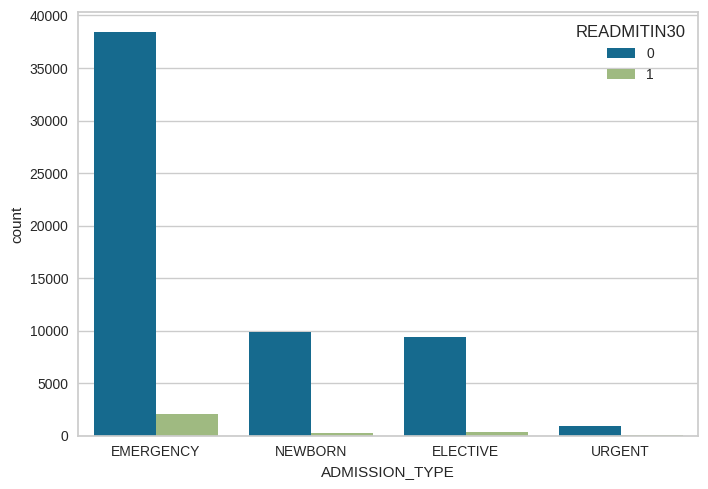

In [92]:
sns.countplot(x = predictors['ADMISSION_TYPE'], hue = predictors['READMITIN30'])

In [93]:
predictors['INSURANCE'].unique()

array(['Medicare', 'Private', 'Government', 'Self Pay', 'Medicaid'],
      dtype=object)

<Axes: xlabel='INSURANCE', ylabel='count'>

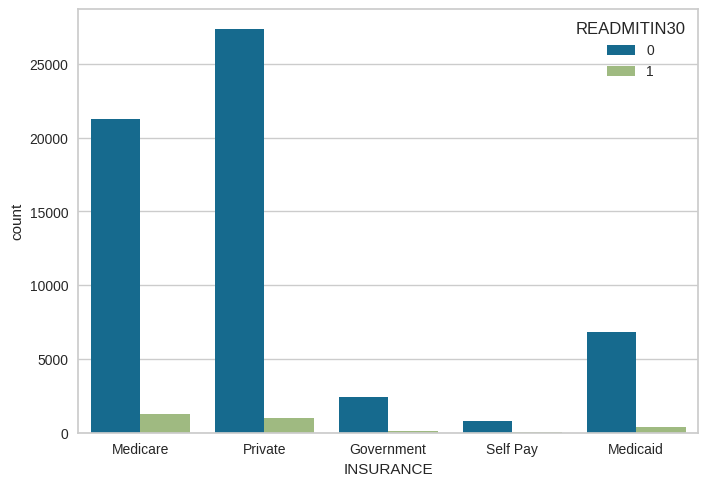

In [94]:
sns.countplot(x = predictors['INSURANCE'], hue = predictors['READMITIN30'])

In [95]:
predictors['LANGUAGE'].unique()

array(['ENGL', 'unknown', 'SPAN', 'RUSS', 'PORT', 'HAIT', 'CANT', 'VIET',
       'CAPE', 'CAMB', 'MAND', 'PTUN', 'TURK', 'FREN', 'ITAL', 'ALBA',
       'PERS', '*GUJ', 'SOMA', 'ETHI', 'AMER', '*BEN', 'HIND', 'KORE',
       '*ARA', 'BENG', 'ARAB', '*YOR', 'POLI', '*LEB', '* BE', 'GREE',
       '*CDI', '*DEA', 'THAI', '*CHI', '* FU', '*TEL', '*AMH', '*HUN',
       '*PHI', 'URDU', '*FIL', '*ARM', 'LAOT', '** T', '*KHM', '*IBO',
       '*SPA', '*TOI', 'JAPA', 'TAGA', '*PER', '*DUT', '*TAM', '*BUL',
       '*BOS', '*MAN', '*FAR', '*MOR'], dtype=object)

<Axes: xlabel='LANGUAGE', ylabel='count'>

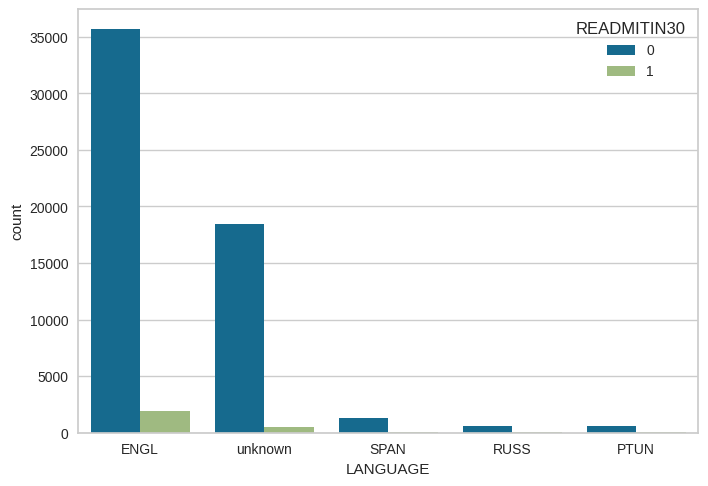

In [96]:
top_languages = predictors['LANGUAGE'].value_counts().nlargest(5).index
filtered_predictors = predictors[predictors['LANGUAGE'].isin(top_languages)]
sns.countplot(x=filtered_predictors['LANGUAGE'], hue=filtered_predictors['READMITIN30'])



In [97]:
#Calculate the top 10 value counts
top_10_languages = predictors['LANGUAGE'].value_counts().head(10).index.tolist()


In [98]:
predictors = predictors[predictors['LANGUAGE'].isin(top_10_languages)]

In [99]:
predictors.shape

(60594, 15)

In [100]:
predictors['LANGUAGE'].unique()

array(['ENGL', 'unknown', 'SPAN', 'RUSS', 'PORT', 'HAIT', 'CANT', 'CAPE',
       'MAND', 'PTUN'], dtype=object)

In [101]:
predictors['ETHNICITY'].unique()

array(['WHITE', 'HISPANIC OR LATINO', 'OTHER', 'UNKNOWN/NOT SPECIFIED',
       'BLACK/AFRICAN AMERICAN', 'ASIAN', 'BLACK/AFRICAN',
       'PATIENT DECLINED TO ANSWER', 'ASIAN - CHINESE',
       'HISPANIC/LATINO - DOMINICAN', 'AMERICAN INDIAN/ALASKA NATIVE',
       'UNABLE TO OBTAIN', 'BLACK/CAPE VERDEAN', 'MULTI RACE ETHNICITY',
       'HISPANIC/LATINO - PUERTO RICAN', 'BLACK/HAITIAN',
       'WHITE - OTHER EUROPEAN', 'HISPANIC/LATINO - COLOMBIAN',
       'HISPANIC/LATINO - GUATEMALAN',
       'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER',
       'ASIAN - ASIAN INDIAN', 'WHITE - BRAZILIAN', 'ASIAN - FILIPINO',
       'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)', 'WHITE - RUSSIAN',
       'PORTUGUESE', 'ASIAN - OTHER', 'SOUTH AMERICAN',
       'WHITE - EASTERN EUROPEAN', 'HISPANIC/LATINO - SALVADORAN',
       'MIDDLE EASTERN', 'ASIAN - VIETNAMESE', 'HISPANIC/LATINO - CUBAN',
       'CARIBBEAN ISLAND', 'ASIAN - KOREAN', 'HISPANIC/LATINO - MEXICAN',
       'ASIAN - JAPANESE', 'HISPANIC/LATI

In [102]:
predictors['MARITAL_STATUS'].unique()

array(['MARRIED', 'UNKNOWN (DEFAULT)', 'SINGLE', 'WIDOWED', 'DIVORCED',
       'SEPARATED', 'LIFE PARTNER'], dtype=object)

<Axes: xlabel='MARITAL_STATUS', ylabel='count'>

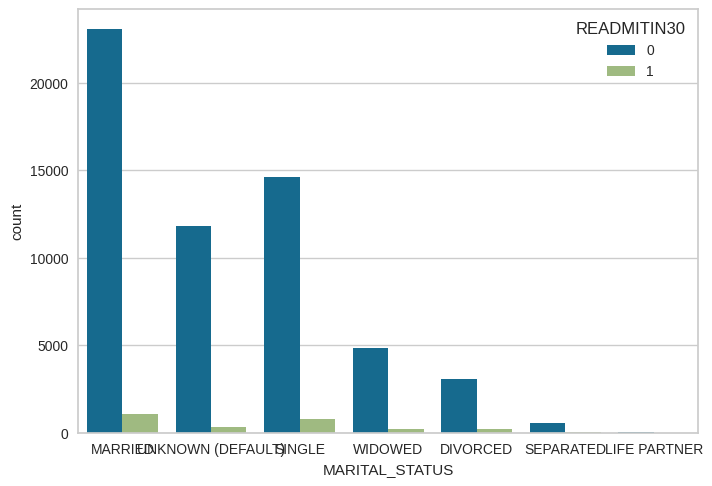

In [103]:
sns.countplot(x = predictors['MARITAL_STATUS'], hue = predictors['READMITIN30'])

In [104]:
predictors['ETHNICITY'].unique()

array(['WHITE', 'HISPANIC OR LATINO', 'OTHER', 'UNKNOWN/NOT SPECIFIED',
       'BLACK/AFRICAN AMERICAN', 'ASIAN', 'BLACK/AFRICAN',
       'PATIENT DECLINED TO ANSWER', 'ASIAN - CHINESE',
       'HISPANIC/LATINO - DOMINICAN', 'AMERICAN INDIAN/ALASKA NATIVE',
       'UNABLE TO OBTAIN', 'BLACK/CAPE VERDEAN', 'MULTI RACE ETHNICITY',
       'HISPANIC/LATINO - PUERTO RICAN', 'BLACK/HAITIAN',
       'WHITE - OTHER EUROPEAN', 'HISPANIC/LATINO - COLOMBIAN',
       'HISPANIC/LATINO - GUATEMALAN',
       'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER',
       'ASIAN - ASIAN INDIAN', 'WHITE - BRAZILIAN', 'ASIAN - FILIPINO',
       'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)', 'WHITE - RUSSIAN',
       'PORTUGUESE', 'ASIAN - OTHER', 'SOUTH AMERICAN',
       'WHITE - EASTERN EUROPEAN', 'HISPANIC/LATINO - SALVADORAN',
       'MIDDLE EASTERN', 'ASIAN - VIETNAMESE', 'HISPANIC/LATINO - CUBAN',
       'CARIBBEAN ISLAND', 'ASIAN - KOREAN', 'HISPANIC/LATINO - MEXICAN',
       'ASIAN - JAPANESE', 'HISPANIC/LATI

In [104]:
# top_10_ethnicities = predictors['ETHNICITY'].value_counts().head(10).index.tolist()
# predictors = predictors[predictors['ETHNICITY'].isin(top_10_ethnicities)]

In [105]:
predictors['ETHNICITY'].unique()

array(['WHITE', 'HISPANIC OR LATINO', 'OTHER', 'UNKNOWN/NOT SPECIFIED',
       'BLACK/AFRICAN AMERICAN', 'ASIAN', 'BLACK/AFRICAN',
       'PATIENT DECLINED TO ANSWER', 'ASIAN - CHINESE',
       'HISPANIC/LATINO - DOMINICAN', 'AMERICAN INDIAN/ALASKA NATIVE',
       'UNABLE TO OBTAIN', 'BLACK/CAPE VERDEAN', 'MULTI RACE ETHNICITY',
       'HISPANIC/LATINO - PUERTO RICAN', 'BLACK/HAITIAN',
       'WHITE - OTHER EUROPEAN', 'HISPANIC/LATINO - COLOMBIAN',
       'HISPANIC/LATINO - GUATEMALAN',
       'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER',
       'ASIAN - ASIAN INDIAN', 'WHITE - BRAZILIAN', 'ASIAN - FILIPINO',
       'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)', 'WHITE - RUSSIAN',
       'PORTUGUESE', 'ASIAN - OTHER', 'SOUTH AMERICAN',
       'WHITE - EASTERN EUROPEAN', 'HISPANIC/LATINO - SALVADORAN',
       'MIDDLE EASTERN', 'ASIAN - VIETNAMESE', 'HISPANIC/LATINO - CUBAN',
       'CARIBBEAN ISLAND', 'ASIAN - KOREAN', 'HISPANIC/LATINO - MEXICAN',
       'ASIAN - JAPANESE', 'HISPANIC/LATI

In [106]:
predictors.shape

(60594, 15)

In [107]:
predictors['DRG_CODE'].unique()

array([ 533,  242,  391, ..., 1764, 2224,  505])

In [108]:
# top_10_drgcodes = predictors['DRG_CODE'].value_counts().head(10).index.tolist()
# predictors = predictors[predictors['DRG_CODE'].isin(top_10_drgcodes)]

In [108]:
predictors['DRG_TYPE'].unique()

array(['HCFA', 'APR ', 'MS'], dtype=object)

<Axes: xlabel='DRG_TYPE', ylabel='count'>

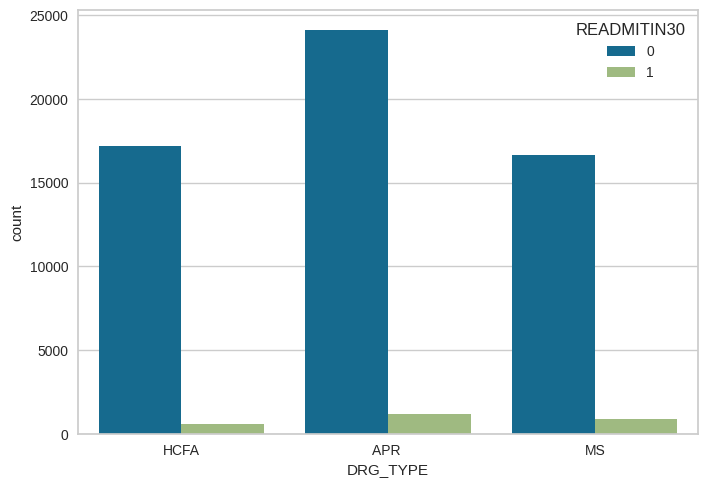

In [109]:
sns.countplot(x = predictors['DRG_TYPE'], hue = predictors['READMITIN30'])

In [110]:
predictors['GENDER'].unique()

array(['F', 'M'], dtype=object)

<Axes: xlabel='GENDER', ylabel='count'>

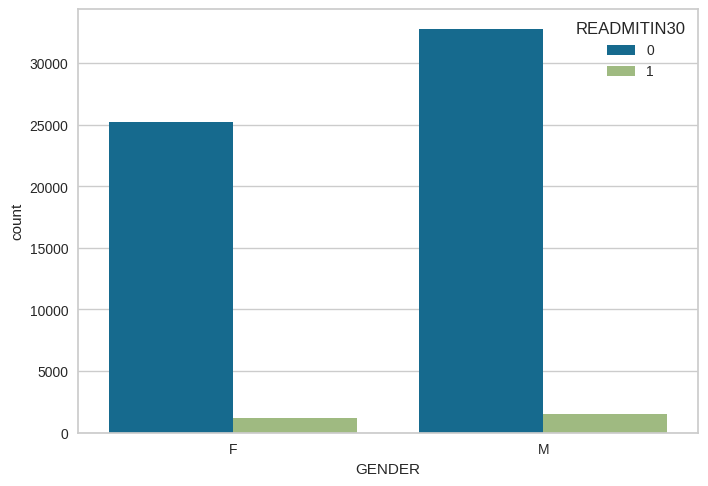

In [111]:
sns.countplot(x = predictors['GENDER'], hue = predictors['READMITIN30'])

#### Assumption
Replacing unknown age with mean age

In [112]:
mean_age = predictors['AGE'].mean()
predictors['AGE'] = predictors['AGE'].replace('unknown', mean_age)


In [113]:
predictors['AGE']

0        -49.0
1        -49.0
2        -81.0
3        -81.0
4       -131.0
         ...  
78609    -80.0
78610    -98.0
78612    -98.0
78613    -55.0
78615    -55.0
Name: AGE, Length: 60594, dtype: float64

In [114]:
mean_duration = predictors['DURATION'].mean()
predictors['DURATION'] = predictors['DURATION'].replace('unknown', mean_duration)


In [115]:
predictors['DURATION'].value_counts()

5.0      7054
3.0      6705
4.0      5733
6.0      5310
7.0      4513
         ... 
151.0       1
128.0       1
141.0       1
104.0       1
138.0       1
Name: DURATION, Length: 152, dtype: int64

In [116]:
predictors.columns

Index(['ADMISSION_TYPE', 'ADMISSION_LOCATION', 'DISCHARGE_LOCATION',
       'INSURANCE', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY',
       'DURATION', 'READMITIN30', 'GENDER', 'AGE', 'DRG_TYPE', 'DRG_CODE',
       'COUNT_ABNORMAL'],
      dtype='object')

## Model Development

In [117]:
predictors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60594 entries, 0 to 78615
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ADMISSION_TYPE      60594 non-null  object 
 1   ADMISSION_LOCATION  60594 non-null  object 
 2   DISCHARGE_LOCATION  60594 non-null  object 
 3   INSURANCE           60594 non-null  object 
 4   LANGUAGE            60594 non-null  object 
 5   RELIGION            60594 non-null  object 
 6   MARITAL_STATUS      60594 non-null  object 
 7   ETHNICITY           60594 non-null  object 
 8   DURATION            60594 non-null  float64
 9   READMITIN30         60594 non-null  int64  
 10  GENDER              60594 non-null  object 
 11  AGE                 60594 non-null  float64
 12  DRG_TYPE            60594 non-null  object 
 13  DRG_CODE            60594 non-null  int64  
 14  COUNT_ABNORMAL      60594 non-null  int64  
dtypes: float64(2), int64(3), object(10)
memory usage: 7.4

In [118]:
predictors['AGE'] = predictors['AGE'].astype(int)

In [119]:
predictors['DURATION'] = predictors['DURATION'].astype(int)

In [120]:
predictors['DRG_CODE'] = predictors['DRG_CODE'].astype(object)

In [121]:
predictors.dtypes

ADMISSION_TYPE        object
ADMISSION_LOCATION    object
DISCHARGE_LOCATION    object
INSURANCE             object
LANGUAGE              object
RELIGION              object
MARITAL_STATUS        object
ETHNICITY             object
DURATION               int64
READMITIN30            int64
GENDER                object
AGE                    int64
DRG_TYPE              object
DRG_CODE              object
COUNT_ABNORMAL         int64
dtype: object

In [262]:
# X = predictors
# predictorsnew = predictors[['ADMISSION_TYPE','INSURANCE', 'LANGUAGE', 'RELIGION',
#        'MARITAL_STATUS', 'ETHNICITY', 'DURATION','GENDER', 'AGE','DRG_TYPE', 'DRG_CODE', 'FLAG']]

In [122]:
#target variable
y = predictors.pop('READMITIN30')

Standardize numerical variables

In [123]:

scaler = StandardScaler()
predictors[['DURATION', 'COUNT_ABNORMAL', 'AGE']] = scaler.fit_transform(predictors[['DURATION', 'COUNT_ABNORMAL','AGE']])


In [124]:
predictors.shape

(60594, 14)

In [125]:
predictors.columns

Index(['ADMISSION_TYPE', 'ADMISSION_LOCATION', 'DISCHARGE_LOCATION',
       'INSURANCE', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY',
       'DURATION', 'GENDER', 'AGE', 'DRG_TYPE', 'DRG_CODE', 'COUNT_ABNORMAL'],
      dtype='object')

Perform one-hot encoding on categorical variables

In [126]:

predictors_encoded = pd.get_dummies(predictors, columns=['ADMISSION_TYPE','ADMISSION_LOCATION', 'DISCHARGE_LOCATION','INSURANCE','LANGUAGE', 'RELIGION','MARITAL_STATUS', 'ETHNICITY', 'GENDER', 'DRG_TYPE', 'DRG_CODE' ])


In [127]:
len(predictors_encoded.columns)

1717

In [128]:
X = predictors_encoded


In [138]:
y = y.astype(int)

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [130]:
y_train.value_counts()

0    46351
1     2124
Name: READMITIN30, dtype: int64

### Logistic Regression

In [133]:
classifier_logistic = LogisticRegression(solver='newton-cg')
classifier_logistic.fit(X_train, y_train)
y_pred = classifier_logistic.predict(X_test)
# y_pred = (y_prob > 0.20).astype(int)
confusion_matrix_ = confusion_matrix(y_test, y_pred)
print(confusion_matrix_)
print(classification_report(y_test, y_pred))

[[11572    16]
 [  528     3]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     11588
           1       0.16      0.01      0.01       531

    accuracy                           0.96     12119
   macro avg       0.56      0.50      0.49     12119
weighted avg       0.92      0.96      0.93     12119



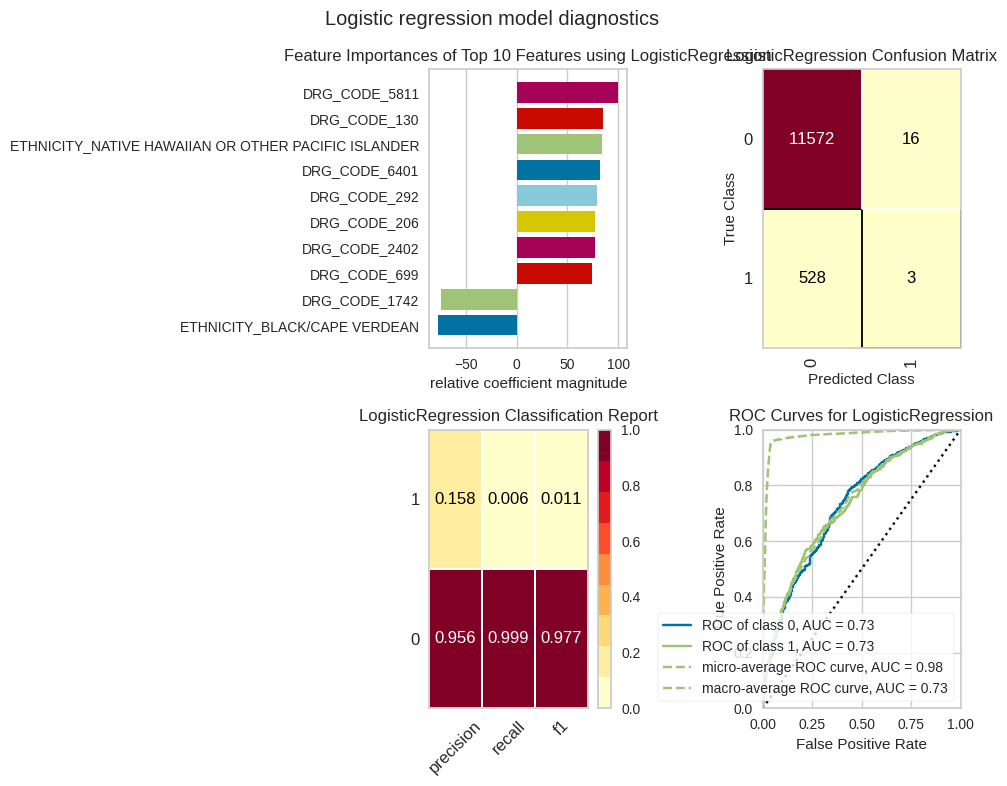

In [134]:

fig, axes = plt.subplots(2, 2, figsize= (10,8))

model = classifier_logistic
visualgrid = [
    FeatureImportances(model, ax=axes[0][0], topn = 10),
    ConfusionMatrix(model, ax=axes[0][1]),
    ClassificationReport(model, ax=axes[1][0]),
    ROCAUC(model, classes = ['0', '1'], ax=axes[1][1]),
]

for viz in visualgrid:
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    viz.finalize()
plt.subplots_adjust(hspace=0.5, wspace=0.7)
for ax in axes.flat:
    if isinstance(ax, FeatureImportances):
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.rcParams["figure.figsize"] = [12, 10]
plt.suptitle('Logistic regression model diagnostics');
plt.tight_layout();

In [166]:
importances = {}

# normalize coefficients
total = sum([abs(x) for x in classifier_logistic.coef_[0]])
normed = [abs(x)/total for x in classifier_logistic.coef_[0]]
for k, v in zip(X.columns, normed):
    importances[k] = v
relative_imp = {k: v for k, v in sorted(importances.items(), key=lambda item: item[1], reverse=True)}
keys =[]
values = []
for k, v in relative_imp.items():
    keys.append(k)
    values.append(v*100)

df = pd.DataFrame(data={'feature': keys, 'important (%)': values})

In [167]:
df.head(10)

,feature,important (%)
0,DRG_CODE_5811,0.390538
1,ETHNICITY_BLACK/CAPE VERDEAN,0.350754
2,ETHNICITY_MIDDLE EASTERN,0.315299
3,DRG_CODE_6401,0.312391
4,DRG_CODE_6933,0.308068
5,DRG_CODE_168,0.306680
6,DRG_CODE_73,0.305888
7,DRG_CODE_92,0.290791
8,DRG_CODE_292,0.289342
9,DRG_CODE_2402,0.282548


### Fine Tuning Logistic Regression

In [158]:
classifier_logistic = LogisticRegression(solver='newton-cg')
classifier_logistic.fit(X_train, y_train)
y_prob= classifier_logistic.predict_proba(X_test)
y_pred = (y_prob[:,1] > 0.05).astype(int)


In [160]:
confusion_matrix_ = confusion_matrix(y_test, y_pred, labels = [0,1])
print(confusion_matrix_)
print(classification_report(y_test, y_pred))

[[8749 2839]
 [ 223  308]]
              precision    recall  f1-score   support

           0       0.98      0.76      0.85     11588
           1       0.10      0.58      0.17       531

    accuracy                           0.75     12119
   macro avg       0.54      0.67      0.51     12119
weighted avg       0.94      0.75      0.82     12119



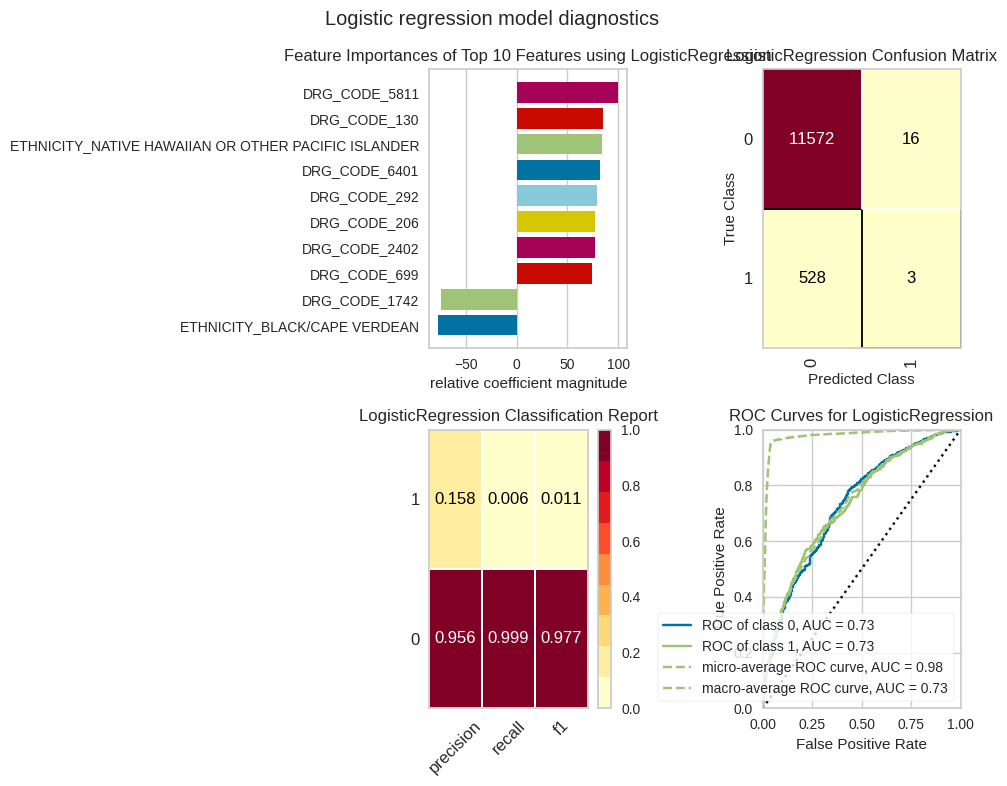

In [161]:
fig, axes = plt.subplots(2, 2, figsize= (10,8))

model = classifier_logistic
visualgrid = [
    FeatureImportances(model, ax=axes[0][0], topn = 10),
    ConfusionMatrix(model, ax=axes[0][1]),
    ClassificationReport(model, ax=axes[1][0]),
    ROCAUC(model, classes = ['0', '1'], ax=axes[1][1]),
]

for viz in visualgrid:
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    viz.finalize()
plt.subplots_adjust(hspace=0.5, wspace=0.7)
for ax in axes.flat:
    if isinstance(ax, FeatureImportances):
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.rcParams["figure.figsize"] = [12, 10]
plt.suptitle('Logistic regression model diagnostics');
plt.tight_layout();

We see a significant improvement in the f1 scores with tuning.

### Desision Tree Classifier

In [168]:
classifier_decision = DecisionTreeClassifier()
classifier_decision.fit(X_train, y_train)
y_pred = classifier_decision.predict(X_test)

In [169]:
confusion_matrix_ = confusion_matrix(y_test, y_pred)
print(confusion_matrix_)
print(classification_report(y_test, y_pred))

[[11263   325]
 [  397   134]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     11588
           1       0.29      0.25      0.27       531

    accuracy                           0.94     12119
   macro avg       0.63      0.61      0.62     12119
weighted avg       0.94      0.94      0.94     12119



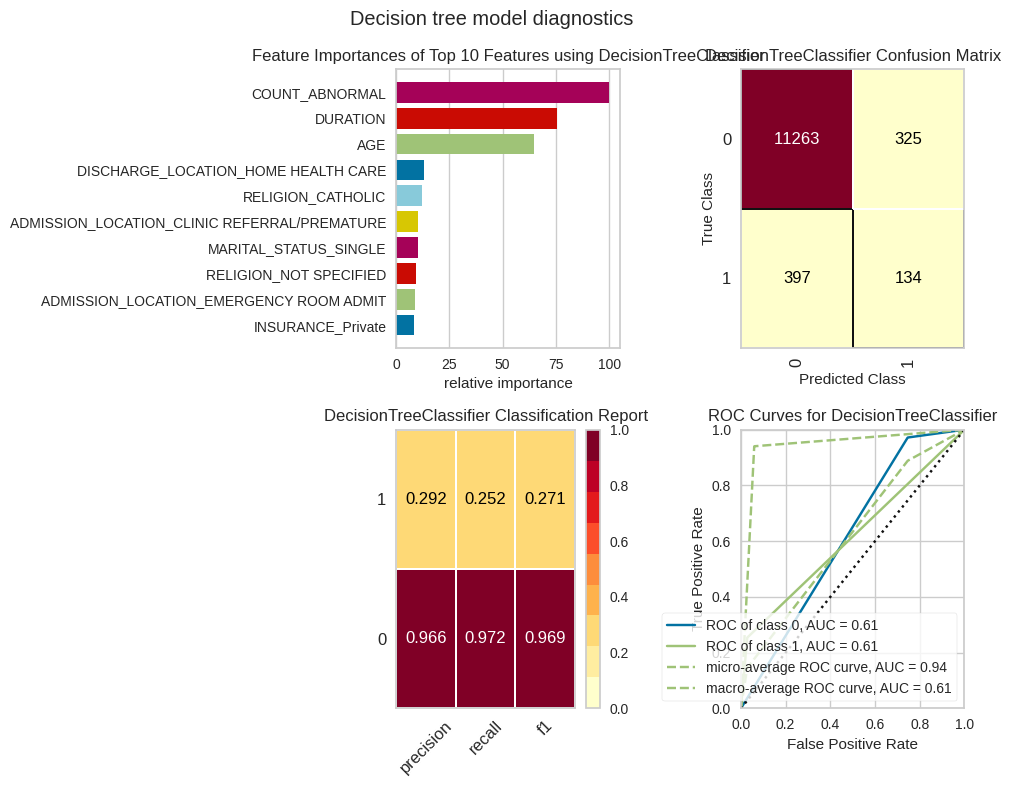

In [170]:
fig, axes = plt.subplots(2, 2, figsize= (10,8))

model = classifier_decision
visualgrid = [
    FeatureImportances(model, ax=axes[0][0], topn = 10),
    ConfusionMatrix(model, ax=axes[0][1]),
    ClassificationReport(model, ax=axes[1][0]),
    ROCAUC(model, classes = ['0', '1'], ax=axes[1][1]),
]

for viz in visualgrid:
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    viz.finalize()
plt.subplots_adjust(hspace=0.5, wspace=0.7)
for ax in axes.flat:
    if isinstance(ax, FeatureImportances):
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.rcParams["figure.figsize"] = [12, 10]
plt.suptitle('Decision tree model diagnostics');
plt.tight_layout();




## Fine tuning Decision trees

In [162]:
classifier_decision = DecisionTreeClassifier()
classifier_decision.fit(X_train, y_train)
y_prob= classifier_decision.predict_proba(X_test)
y_pred = (y_prob[:,1] > 0.05).astype(int)




In [163]:
confusion_matrix_ = confusion_matrix(y_test, y_pred)
print(confusion_matrix_)
print(classification_report(y_test, y_pred))

[[11270   318]
 [  413   118]]
              precision    recall  f1-score   support

           0       0.96      0.97      0.97     11588
           1       0.27      0.22      0.24       531

    accuracy                           0.94     12119
   macro avg       0.62      0.60      0.61     12119
weighted avg       0.93      0.94      0.94     12119



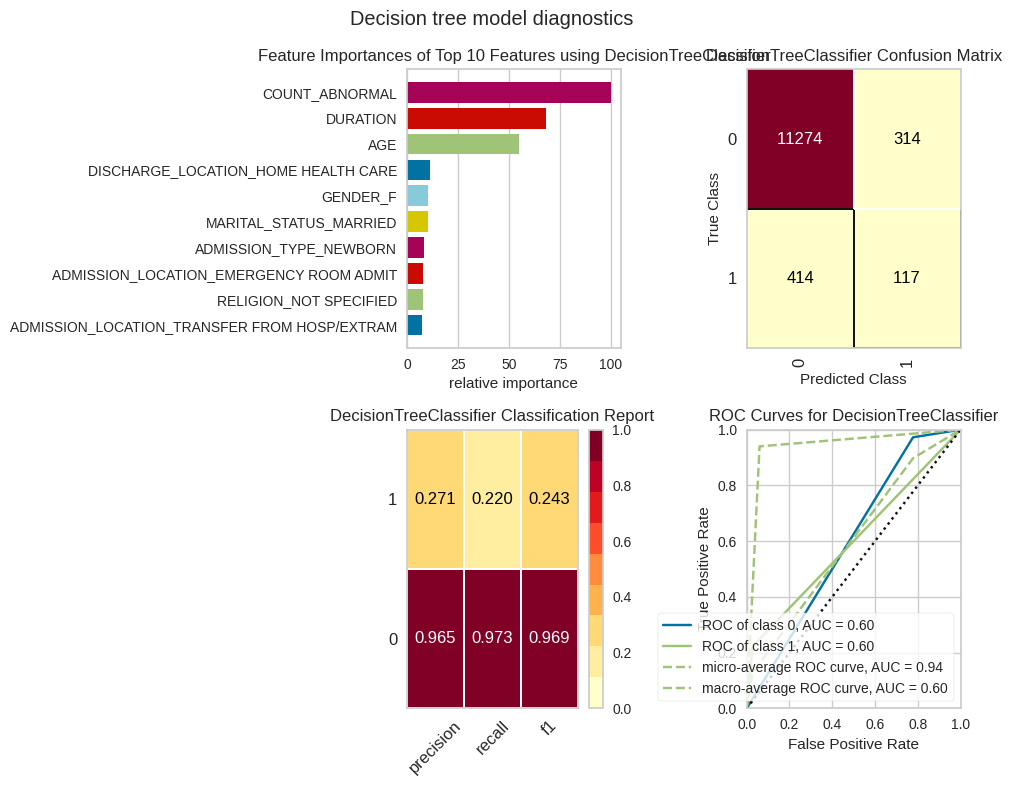

In [164]:
fig, axes = plt.subplots(2, 2, figsize= (10,8))

model = classifier_decision
visualgrid = [
    FeatureImportances(model, ax=axes[0][0], topn = 10),
    ConfusionMatrix(model, ax=axes[0][1]),
    ClassificationReport(model, ax=axes[1][0]),
    ROCAUC(model, classes = ['0', '1'], ax=axes[1][1]),
]

for viz in visualgrid:
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    viz.finalize()
plt.subplots_adjust(hspace=0.5, wspace=0.7)
for ax in axes.flat:
    if isinstance(ax, FeatureImportances):
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.rcParams["figure.figsize"] = [12, 10]
plt.suptitle('Decision tree model diagnostics');
plt.tight_layout();


## Random Forest Classifier

In [171]:
classifier_rf = RandomForestClassifier()
classifier_rf.fit(X_train, y_train)

RandomForestClassifier()

In [172]:
y_pred = classifier_rf.predict(X_test)

In [173]:
confusion_matrix_ = confusion_matrix(y_test, y_pred)
print(confusion_matrix_)
print(classification_report(y_test, y_pred))

[[11565    23]
 [  519    12]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     11588
           1       0.34      0.02      0.04       531

    accuracy                           0.96     12119
   macro avg       0.65      0.51      0.51     12119
weighted avg       0.93      0.96      0.94     12119



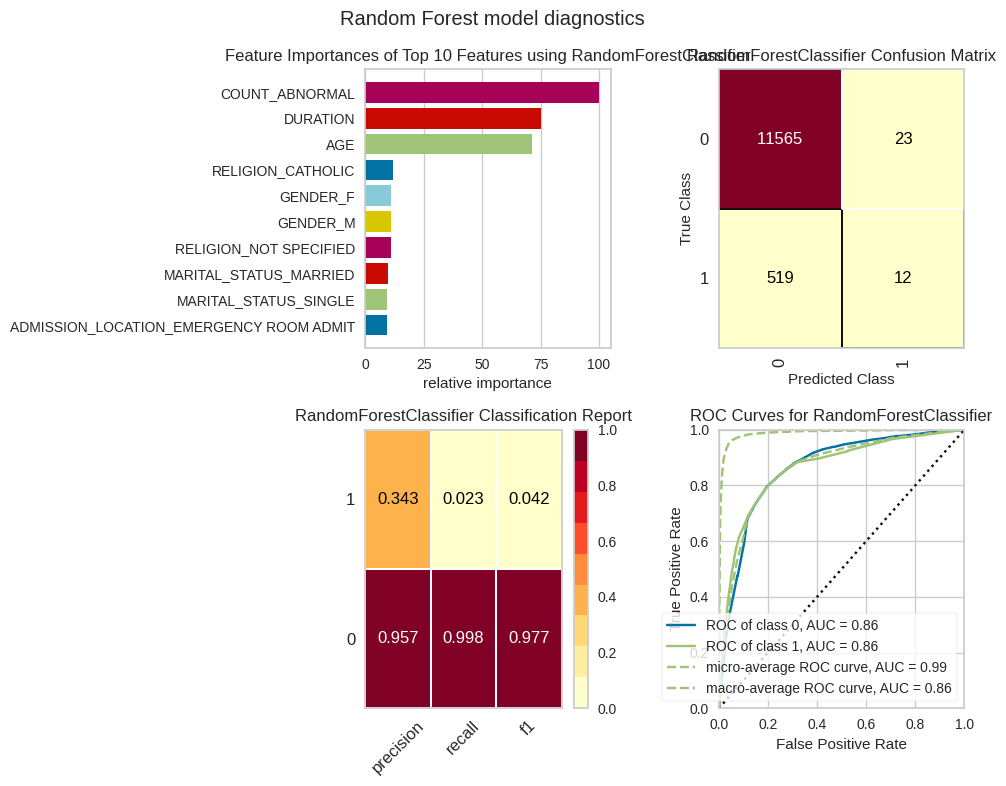

In [174]:
fig, axes = plt.subplots(2, 2, figsize= (10,8))

model = classifier_rf
visualgrid = [
    FeatureImportances(model, ax=axes[0][0], topn = 10),
    ConfusionMatrix(model, ax=axes[0][1]),
    ClassificationReport(model, ax=axes[1][0]),
    ROCAUC(model, classes = ['0', '1'], ax=axes[1][1]),
]

for viz in visualgrid:
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    viz.finalize()
plt.subplots_adjust(hspace=0.5, wspace=0.7)
for ax in axes.flat:
    if isinstance(ax, FeatureImportances):
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.rcParams["figure.figsize"] = [12, 10]
plt.suptitle('Random Forest model diagnostics');
plt.tight_layout();

## XGBoost

In [177]:
xgb_clasifier = xgb.XGBClassifier()
xgb_clasifier.fit(X_train,y_train)
y_pred_xg= xgb_clasifier.predict(X_test)
print(confusion_matrix(y_test, y_pred_xg))
print(classification_report(y_test, y_pred_xg))
print(accuracy_score(y_test,y_pred_xg))


[[11569    19]
 [  515    16]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     11588
           1       0.46      0.03      0.06       531

    accuracy                           0.96     12119
   macro avg       0.71      0.51      0.52     12119
weighted avg       0.94      0.96      0.94     12119

0.9559369584949253


Conclusions and Insights to follow in presentation